Задача 3: Исследование простых нейронных сетей.
▫️ Наличие решения. (60.0)
▫️ Хорошее решение. (0.0)
Баллы: 60.0 / 60.0

In [16]:
import typing as tp

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
from torch import nn

sns.set(font_scale=1.4, palette='Set2')

## Исследование простой модели (60 баллов)

Это последний ноутбук в данном домашнем задании. Здесь вы исследуете влияние величины линейного слоя, инициализации и разных функций активации на обучение простой двухслойной модели. В качестве данных будет использоваться синтетическая выборка соответствующая примеру на лекции.

В данном ноутбуке **можно и нужно пользоваться PyTorch**. Все эксперименты будут вычислительно простыми, поэтому CUDA здесь не понадобится.

### 1. Реализация

Рассмотрим функцию с лекции:
$$f(x) = 0.2 + 1.4 x^2 + 0.3\sin(15x) + 0.1\cos(50x)$$
Будем приближать эту функции на отрезке $[0, 1]$ двухслойной нейронной сетью.
* Первый слой будет содержать обучаемые веса и смещения. А также некоторую функцию активации $\sigma(x)$.
* Второй слой будет содержать только обучаемые веса (без смещения), а функция активации будет тождественной.

Если в качестве $\sigma(x)$ взять функцию индикатора, то поулчится нейронная сеть точь в точь такая же как на лекции.

Начнем с простого. Реализуйте заданную функцию.

In [2]:
def function(x: torch.Tensor):
    """ Функция f(x) """
    return 0.2 + 1.4 * x ** 2 + 0.3 * torch.sin(15*x) + 0.1 * torch.cos(50*x)

In [3]:
assert torch.allclose(function(torch.tensor(0)), torch.tensor(0.3), 1e-4)
assert torch.allclose(function(torch.tensor(1)), torch.tensor(1.8916), 1e-4)
assert torch.allclose(function(torch.tensor(0.5)), torch.tensor(0.9305), 1e-4)

Реализуйте модель двухслойной нейронной сети как в описании.

In [4]:
class MyModel(torch.nn.Module):
    """
    Двухслойная нейронная сеть.
    * n_hidden - количество нейронов на первом слое;
    * activation - функция активации на первом слое.
    """

    def __init__(
            self, n_hidden: int,
            activation: tp.Callable[[torch.Tensor], torch.Tensor]):
        
        super(MyModel, self).__init__()
        self.n_hidden = n_hidden
        self.activation = activation
        self.lay1 = nn.Linear(1, self.n_hidden)
        self.lay2 = nn.Linear(self.n_hidden, 1)



    def forward(self, x):
        out = self.lay2(self.activation(self.lay1(x)))
        return out

Сгенерируйте значения $x$ с помощью равномерной сетки с шагом 0.01 на отрезке $[0, 1]$. Также посчитайте соответствующие значения $f(x)$.

In [5]:
x = torch.linspace(0, 1, 101).view(-1, 1)
y_true = function(x)
assert x.shape == y_true.shape == (101, 1)

Напишите функцию для обучения сети. В данном случае, мы будем подавать в сеть всю выборку сразу, поэтому нет необходимости по ней итерироваться. По ходу обучения будет сохраняться поле `loss`. Это скаляр, поэтому при сохранении используем метод тензора `item`.

In [7]:
def train(model, optimizer, criterion, x, y, n_epochs):
    """
    Цикл обучения нейронной сети.
    * model - модель;
    * optimizer - оптимизатор;
    * critetion - функция ошибки;
    * x - входные данные;
    * y - выходные данные;
    * n_epochs - количество эпох обучения;
    """

    # история обучения
    history = {'loss': []}

    # вводим в привычку
    model.train()

    # цикл обучения
    for i in range(n_epochs):
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        history['loss'].append(loss.item())

    return history

Напишите функцию для получения предсказания. Воспользуйтесь конструкцией, которая позволяет не считать градиенты при прогоне модели.

In [8]:
def eval(model, x):
    """
    Предскзание модели.
    * model - модель;
    * x - входные данные.
    """

    # вводим в привычку
    model.eval()

    y_pred = model(x)
    
    return y_pred

В качестве лосса и метрики будем использовать MSE.

In [9]:
mse = torch.nn.MSELoss()

### 2. Эксперименты

Для начала в качестве функции активации $\sigma(x)$ возьмем индикатор $I\{x > 0\}$ как на лекции.

In [10]:
def indicator(x, threshold=0):
    return (x > threshold).to(torch.float32)

Инициализируйте модель. Сохраним значения весов модели. Сделайте одну итерацию обучения (одну эпоху). В качестве оптимизатора используем `SGD`. Сравните новые веса модели со старыми. Объясните результат.

In [12]:
model = MyModel(n_hidden=100, activation=indicator)

# веса до итерации обучения
w1_init = model.lay1.weight.detach().clone()
b1_init = model.lay1.bias.detach().clone()
w2_init = model.lay2.weight.detach().clone()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
train(model, optimizer, mse, x, y_true, 1)

# веса после итерации обучения
w1_new = model.lay1.weight.detach().clone()
b1_new = model.lay1.bias.detach().clone()
w2_new = model.lay2.weight.detach().clone()

torch.allclose(w1_init, w1_new), torch.allclose(b1_init, b1_new), torch.allclose(w2_init, w2_new)

(True, True, False)

**Ответ:**
Индикаторная функция не дифференцируема, а identity дифф, поэтому у первого слоя не меняются параметры, у второго меняются

Попробуем сгладить наш индикатор. Реализуйте другую функцию активации &mdash; *сигмоиду с температурой*.
Ее отличие от обычной состоит в множителе в показателе экспоненты:

$$f(x) = \frac{1}{1 + e^{-T \cdot x}}$$

In [13]:
def tempered_sigmoid(x, temperature=50):
    """
    Сигмоида с температурой
    * input - входной тензор;
    * T - температура
    """
    return 1 / (1 + torch.exp(-temperature * x))

Визуализируйте зависимость от температуры:

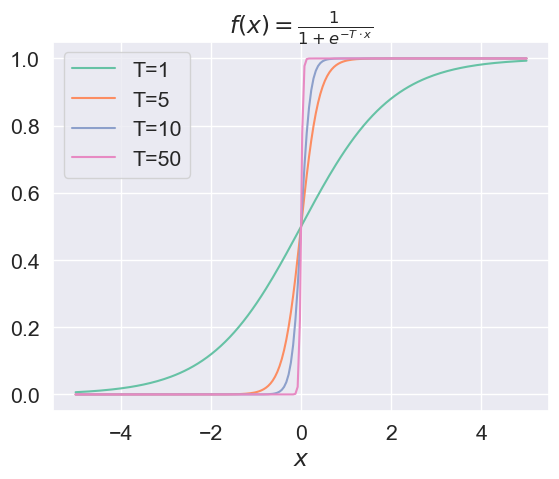

In [14]:
grid = torch.linspace(-5, 5, 200)
temperatures = [1, 5, 10, 50]
for temp in temperatures:
    plt.plot(grid, tempered_sigmoid(grid, temp), label=f'T={temp}')
plt.title('$f(x)=\\frac{1}{1+e^{-T\cdot x}}$')
plt.xlabel('$x$')
plt.legend()
plt.show()

Сравним эти функции активации с еще тремя, которые были у вас на лекции: `ReLU`, `LeakyReLU`, `GELU`. У каждой зададим `learning_rate`.

In [15]:
activation_functions = {
    'Индикатор': [indicator, 0.01],
    'Сигмоида (t)': [tempered_sigmoid, 0.01],
    'ReLU     ': [nn.ReLU(), 0.1],
    'LeakyReLU': [nn.LeakyReLU(), 0.1],
    'GELU     ': [nn.GELU(), 0.1]
}

Инициализируйте и обучите модель с каждой функцией активации 5 раз, и выберете лучшее предсказание по MSE. Построим график с лучшим предсказанием для каждой функции активации. Сравните эти предсказания между собой по MSE. Отличаются ли предсказания в случаях индикаторной функции и сигмоиды?

Индикатор 	 0.1259
Сигмоида (t) 	 0.0986
ReLU      	 0.0639
LeakyReLU 	 0.0606
GELU      	 0.068


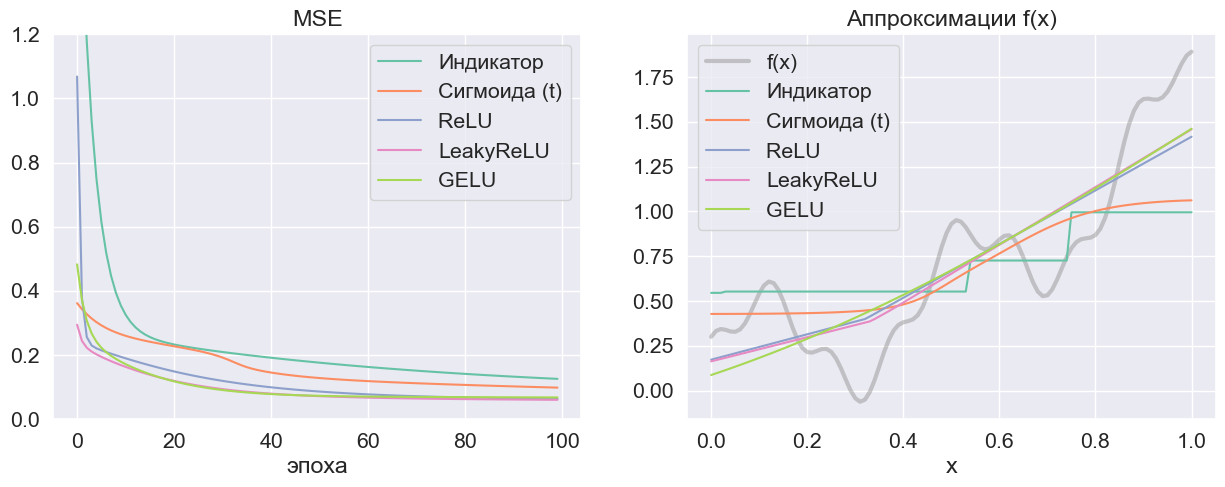

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)',
            color='grey', lw=3, alpha=.4)

n_times = 5
n_hidden = 10
n_epochs = 100

for name, (func, lr) in activation_functions.items():
    MSEs = []
    y_preds = []
    for i in range(n_times):
        model = MyModel(n_hidden=10, activation=func)
        model.train()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        MSEs.append(train(model, optimizer, mse, x, y_true, n_epochs)['loss'])
        model.eval()
        y_preds.append(model(x).detach().numpy())

    MSEs = np.array(MSEs)
    best = np.nanargmin(MSEs[:, -1])
    print(name, '\t', np.round(MSEs[best][-1], 4))

    axs[0].plot(MSEs[best], label=name)
    axs[1].plot(x.ravel(), y_preds[best].ravel(), label=name)

axs[0].legend()
axs[1].legend()
axs[0].set_title('MSE')
axs[1].set_title('Аппроксимации f(x)')
axs[0].set_xlabel('эпоха')
axs[1].set_xlabel('x')
axs[0].set_ylim(0, 1.2)

plt.show()

**Ответ:**
У индикатора самая большая ошибка, у сигмоиды чуть меньше. Остальные примерно одинаково меньше, чем индикатор и сигмодида. Сигмоида очевидно имеет самое гладкое приближение.

Вернемся к индикаторной функции активации. Исследуйте то, как обучается модель в зависимости от ширины первого слоя (ширина = кол-во нейронов). Рассмотрим значения 5, 10, 20, 50, 100.  Теперь будем запускать инициализацию по 100 раз. Не беспокойтесь, считается довольно шустро. Для каждой ширины слоя, построим графики зависимости функции ошибки от эпохи обучения. Также построим график среднего предсказания с доверительным интервалом ширины $2\sigma$ (здесь корень из дисперсии), сравните его с $f(x)$. Сделайте выводы.

In [18]:
n_times = 100

In [19]:
def test_different_hidden_sizes(activation_function):
    sns.set_style("whitegrid")
    n_epochs = 100
    n_times = 100
    for n_hidden in (5, 10, 20, 50, 100):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        y_preds = []
        MSEs = []

        for i in range(n_times):
            model = MyModel(n_hidden=n_hidden, activation=activation_function)
            model.train()
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
            loss_history = train(model, optimizer, mse, x, y_true, n_epochs)['loss']
            model.eval()
            y_pred = model(x)
            MSEs.append(mse(y_pred, y_true))
            y_preds.append(y_pred.ravel().detach())
            axs[0].plot(loss_history, color='blue', alpha=0.1)

        # предсказания, их средние и стандартное отклонение
        y_preds = torch.stack(y_preds)
        y_pred_mean = y_preds.mean(axis=0)
        y_pred_std = torch.sqrt(y_preds.var(axis=0))

        axs[1].plot(x, y_pred_mean, color='blue', label='среднее предсказ.')
        axs[1].fill_between(
            x.ravel(), y_pred_mean - y_pred_std * 2, y_pred_mean + y_pred_std * 2,
            alpha=0.1, color='blue', label='дов. интервал')
        axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)', color='#00BB99', lw=3)

        mse_mean = torch.mean(torch.tensor(MSEs))

        axs[1].legend()
        axs[0].set_title(f'MSE ~ {mse_mean:.2f}')
        axs[1].set_title('Аппроксимации f(x)')
        axs[0].set_xlabel('эпоха')
        axs[1].set_xlabel('x')
        axs[0].set_ylim(0, 1.2)

        fig.suptitle(f'{n_hidden} нейронов в 1-м слое')
        plt.show()

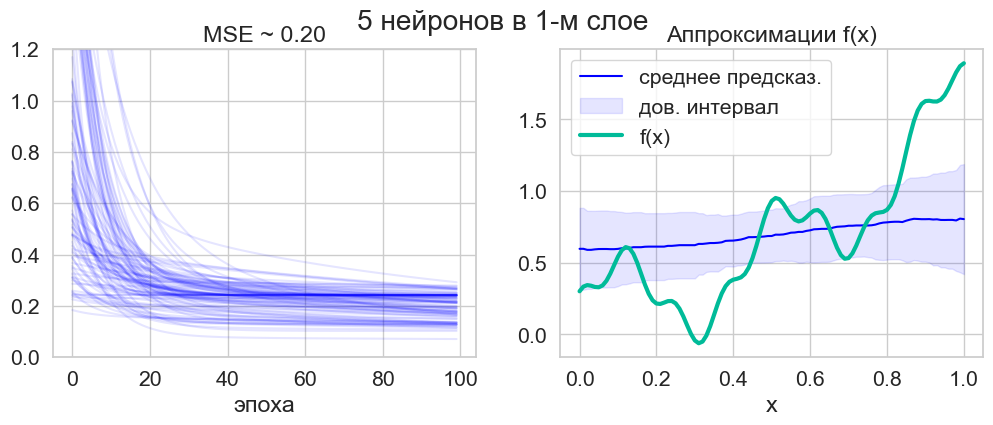

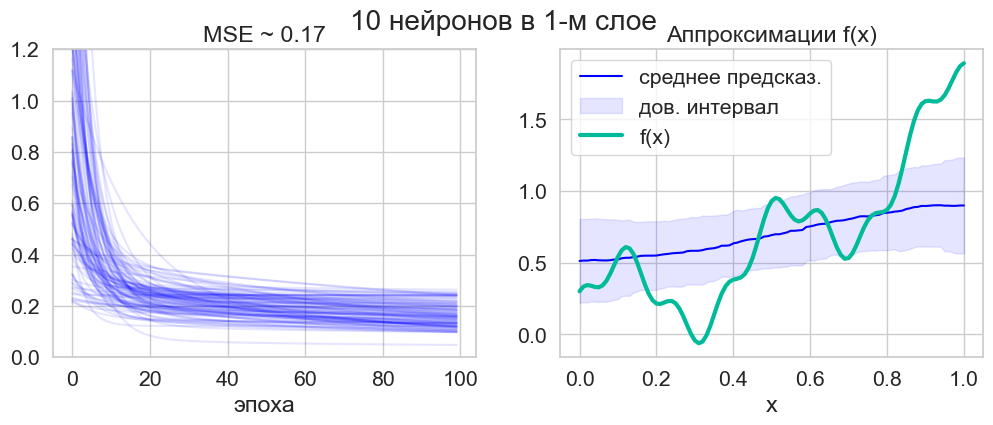

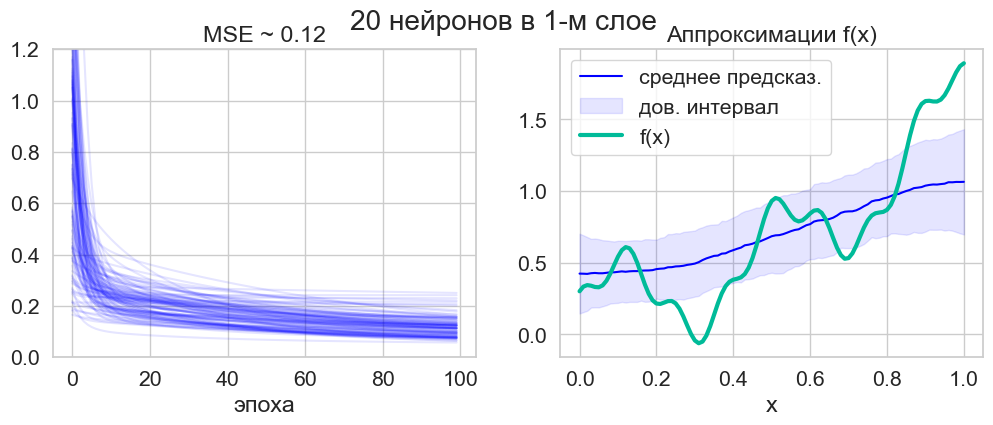

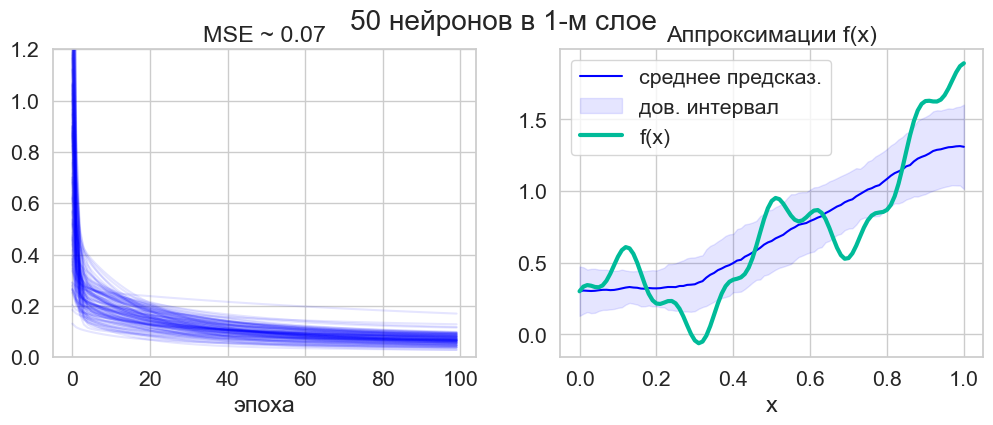

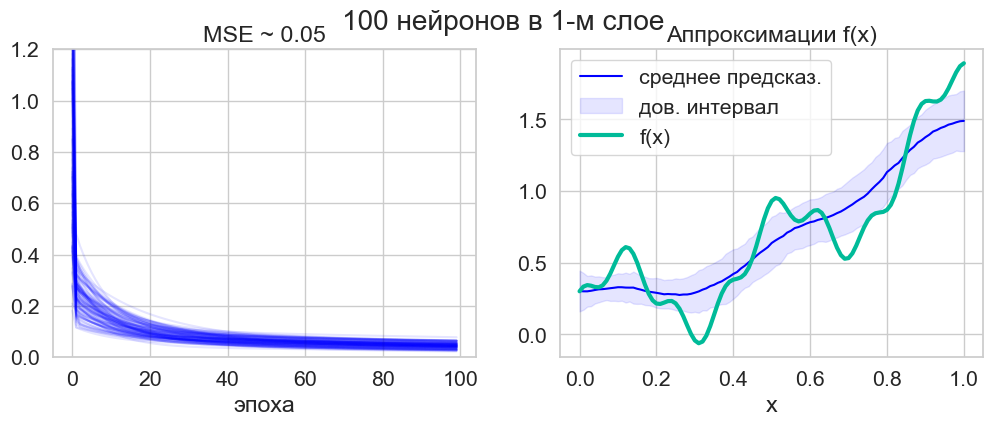

In [20]:
test_different_hidden_sizes(indicator)

Повторите то же самое для функции активации ReLU. Сделайте выводы.

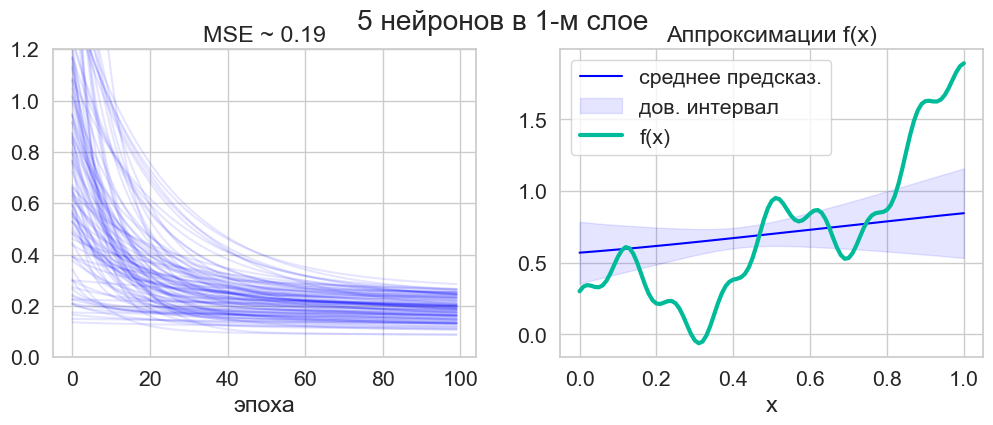

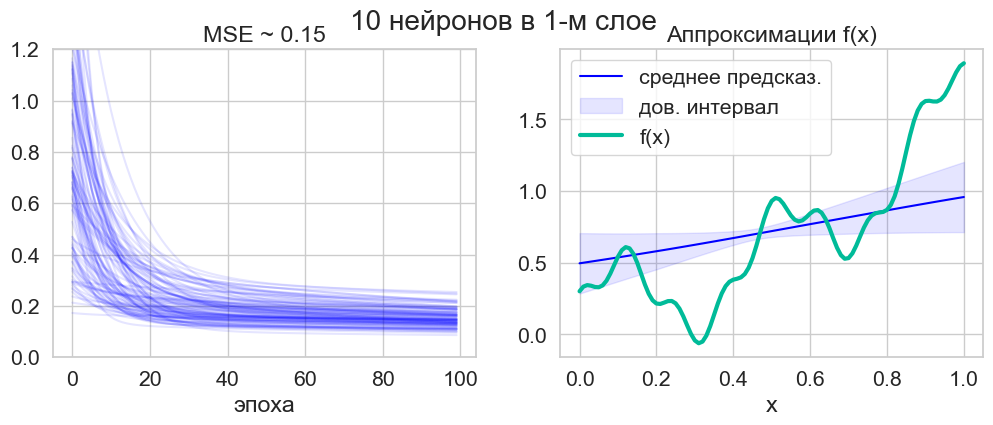

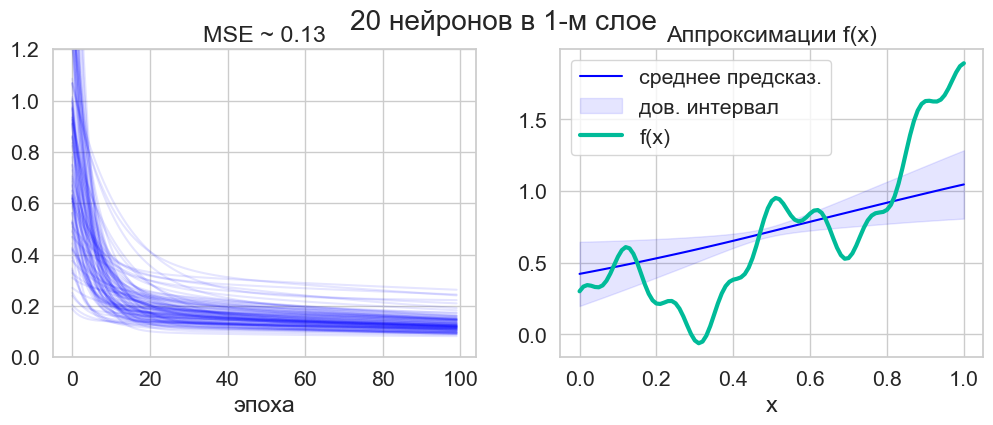

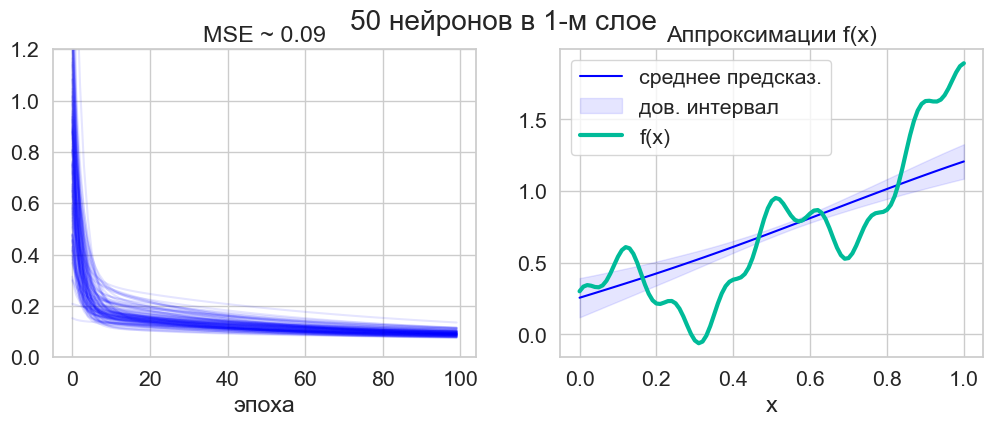

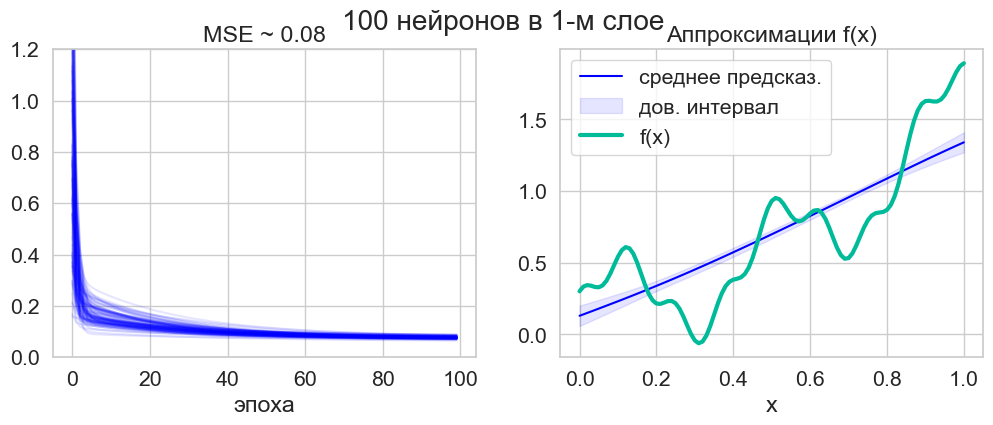

In [21]:
test_different_hidden_sizes(nn.ReLU())

**Ответ:**
По мере увеличения количества нейронов в слое, уменьшается лосс и сужается доверительный интервал для обеих функций активации.
У ReLu покрытие истинной функции намного меньше, чем у индикатора.

---
**Вывод**
Мы использовали модели с линейными слоями, нелинейными активациями и различным числом нейронов для аппроксимации нелинейной функции. Хотя полностью восстановить функцию не удалось, метрика MSE показала достаточно низкие значения.